# Trading Signals with Technical Indicators and Machine Learning

## 1) Introduction
Stock price movement can be effectively analysed using a variety of technical indicators. In this project, I aim to analyse the relationship between technical indicators and stock price, as well as predict whether or not a stock should be bought or sold a stock at a certain time. 

I will use data on historical stock prices and 4 main technical indicators, namely the Simple Moving Average, Exponential Moving Average, Moving Average Convergence/Divergence and the Relative Strength Index, to build a machine learning model that can utilise these technical indicators to classify buy and sell signals.

With this model, I can estimate the best times to buy or sell a stock, and make a more informed decision when I make a trading decision in the future.

### Overview:
- Data Preprocessing
    - In this stage, I will remove redundant columns which might add unneccessary noise to the dataset. I will also ensure all the data is of appropriate data types and ensure no values are missing. In addition, I will conduct an analysis of the dataset to observe and determine any possible trends in the dataset, as well as create new columns that could be useful in helping me to determine buy and sell signals. These would be helpful in ensuring that my machine learning models can be trained effectively and generate accurate buy and sell signals.
- Methodology and Experiments
    - In this section, I will train, validate and test 4 different machine learning models using the technical indicator data that we have obtained via preprocessing. I will also be manually tuning the hyperparameters of the 4 models to maximize each model's performance, since cross validation should not be used on a time series data like stock prices.
    - I will also measure their effectiveness using a variety of classification metrics such as Accuracy, True Positive Rate, True Negative Rate etc.,  which will allow me to compare the different models I have built and determine the model that is most effective in classifying buy and sell signals.
- Conclusion
    - Lastly, I will summarize my findings in this project and determine any limitations and possible improvements I could make.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from yahoo_fin import stock_info as sf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import SGDClassifier, LogisticRegression

sns.set()
random_state = 1
data_dir = 'datasets/'

## 2) Data Preprocessing
The dataset I will be using for this problem will consist of the historical daily stock prices of AAPL from 2015-01-01 to 2019-12-31. The description of the data features are as follows:
- date = Date of trading day
- high = Maximum traded price of AAPL stock on that day
- low = Minimum traded price of AAPL stock on that day
- open = The first traded price of AAPL stock on that day
- close = The last traded price of AAPL stock on that day
- adjclose = Adjusted closing price of the day, after accounting for all applicable splits and dividend distributions
- volume = Number of shares of AAPL stock traded on that day
- ticker = AAPL stock symbol

### 2a) Data Cleaning

In [2]:
stock = 'AAPL'
short_window = 20
medium_window = 50
start_date = '2015-01-01'
end_date = '2019-12-31'

#### Get Stock Data

In [3]:
pre_start_date = dt.date.fromisoformat(start_date) - dt.timedelta(100)  # Buffer data to ensure that all entries after '2015-01-01' are not null after transformation
post_end_date = dt.date.fromisoformat(end_date) + dt.timedelta(1)  # The date range we want must be inclusive on the end_date

stock_df = sf.get_data(ticker=stock, start_date=pre_start_date, end_date=post_end_date, index_as_date=False)
stock_df.to_csv(f'{data_dir}aapl_stock_raw.csv')
stock_df

date       open       high        low      close   adjclose   
0    2014-09-23  25.150000  25.735001  25.135000  25.660000  22.962931  \
1    2014-09-24  25.540001  25.712500  25.299999  25.437500  22.763815   
2    2014-09-25  25.127501  25.177500  24.430000  24.467501  21.895767   
3    2014-09-26  24.632500  25.187500  24.600000  25.187500  22.540092   
4    2014-09-29  24.662500  25.110001  24.657499  25.027500  22.396908   
...         ...        ...        ...        ...        ...        ...   
1323 2019-12-24  71.172501  71.222504  70.730003  71.067497  69.517090   
1324 2019-12-26  71.205002  72.495003  71.175003  72.477501  70.896324   
1325 2019-12-27  72.779999  73.492500  72.029999  72.449997  70.869438   
1326 2019-12-30  72.364998  73.172501  71.305000  72.879997  71.290054   
1327 2019-12-31  72.482498  73.419998  72.379997  73.412498  71.810936   

         volume ticker  
0     253608800   AAPL  
1     240687200   AAPL  
2     400368000   AAPL  
3     249482000   AAPL  
4     199065200   AAPL  
...         ...    ...  
1323   48478800   AAPL  
1324   93121200   AAPL  
1325  146266000   AAPL  
1326  144114400   AAPL  
1327  100805600   AAPL  

[1328 rows x 8 columns]

#### Ensure Appropriate DataTypes no NULL Columns
All columns are of appropriate data types, and there are no NULL columns, so there is no need to make any modifications as of now.

In [4]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328 entries, 0 to 1327
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      1328 non-null   datetime64[ns]
 1   open      1328 non-null   float64       
 2   high      1328 non-null   float64       
 3   low       1328 non-null   float64       
 4   close     1328 non-null   float64       
 5   adjclose  1328 non-null   float64       
 6   volume    1328 non-null   int64         
 7   ticker    1328 non-null   object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 83.1+ KB


#### Remove Redundant and NULL Columns
The ticker column is a redundant column since every entry is populated with the same value ('AAPL'), hence it might lead to unneccessary noise which could affect my models' accuracy, hence I will remove it from the dataset.

In [5]:
stock_df.drop(columns=['ticker'], inplace=True)
stock_df.dropna(inplace=True)
stock_df

date       open       high        low      close   adjclose   
0    2014-09-23  25.150000  25.735001  25.135000  25.660000  22.962931  \
1    2014-09-24  25.540001  25.712500  25.299999  25.437500  22.763815   
2    2014-09-25  25.127501  25.177500  24.430000  24.467501  21.895767   
3    2014-09-26  24.632500  25.187500  24.600000  25.187500  22.540092   
4    2014-09-29  24.662500  25.110001  24.657499  25.027500  22.396908   
...         ...        ...        ...        ...        ...        ...   
1323 2019-12-24  71.172501  71.222504  70.730003  71.067497  69.517090   
1324 2019-12-26  71.205002  72.495003  71.175003  72.477501  70.896324   
1325 2019-12-27  72.779999  73.492500  72.029999  72.449997  70.869438   
1326 2019-12-30  72.364998  73.172501  71.305000  72.879997  71.290054   
1327 2019-12-31  72.482498  73.419998  72.379997  73.412498  71.810936   

         volume  
0     253608800  
1     240687200  
2     400368000  
3     249482000  
4     199065200  
...         ...  
1323   48478800  
1324   93121200  
1325  146266000  
1326  144114400  
1327  100805600  

[1328 rows x 7 columns]

### 2b) Exploratory Data Analysis

#### Analyse Dataset Features

In [6]:
stock_df.describe()

date         open         high          low   
count                           1328  1328.000000  1328.000000  1328.000000  \
mean   2017-05-12 02:19:52.771084288    37.988712    38.324866    37.662664   
min              2014-09-23 00:00:00    22.500000    22.917500    22.367500   
25%              2016-01-18 00:00:00    28.399374    28.631875    28.090625   
50%              2017-05-11 12:00:00    36.120001    36.446251    35.889999   
75%              2018-09-05 06:00:00    45.790000    46.123126    45.243750   
max              2019-12-31 00:00:00    72.779999    73.492500    72.379997   
std                              NaN    11.023229    11.122092    10.945773   

             close     adjclose        volume  
count  1328.000000  1328.000000  1.328000e+03  
mean     38.008274    35.898769  1.470103e+08  
min      22.584999    20.883026  4.544800e+07  
25%      28.386876    25.983138  9.651220e+07  
50%      36.162500    34.077679  1.287770e+08  
75%      45.714375    44.017092  1.779131e+08  
max      73.412498    71.810936  6.488252e+08  
std      11.049321    11.303093  7.292002e+07

#### Get Indicator Data
For this project, I would be focussing on short term (20 days) to medium term (50 days) investing or trading, hence, I must calculate the short and medium term technical indicator data for the Simple Moving Average (SMA), Exponential Moving Average (EMA), Moving Average Convergence/Divergence (MACD) and the Relative Strength Index (RSI):
- SMA = Average close price of AAPL stock in a specified window
- EMA = Weight averaged close price of AAPL stock in a specified window, with more focus on the current price
- MACD = Identifies the momentum of a particular trend, and highlights the relationship between the 12 and 16 day EMAs of AAPL stock price, this is used in tandem with a signal variable, which is the 9 day EMA of MACD
- RSI = Measures the speed and magnitude of AAPL's recent price changes to determines if it is overvalued or undervalued

In [7]:
def getSMA(data, window):
    data[f'sma_{window}'] = data['close'].rolling(window).mean()
    return data

def getEMA(data, window):
    data[f'ema_{window}'] = data['close'].ewm(span=window).mean()
    return data

def getMACD(data):
    data['macd_12'] = data['close'].ewm(span=12).mean()
    data['macd_26'] = data['close'].ewm(span=26).mean()
    data['macd_value'] = data['macd_12'] - data['macd_26']
    data['macd_price_signal'] = data['macd_value'].ewm(span=9).mean()
    data = data.drop(columns=['macd_12', 'macd_26'])
    return data

def getRSI(data, window):
    close_delta = data['close'].diff()
    
    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)
    ma_up = up.ewm(com = window - 1, adjust=True, min_periods = window).mean()
    ma_down = down.ewm(com = window - 1, adjust=True, min_periods = window).mean()
        
    data[f'rsi_{window}'] = 100 - (100/(1 + (ma_up / ma_down)))
    return data

In [8]:
# SMA for both short and medium windows
stock_df = getSMA(stock_df, short_window)
stock_df = getSMA(stock_df, medium_window)

# EMA for both short and medium windows
stock_df = getEMA(stock_df, short_window)
stock_df = getEMA(stock_df, medium_window)

# MACD
stock_df = getMACD(stock_df)

# RSI for both short and medium windows
stock_df = getRSI(stock_df, short_window)
stock_df = getRSI(stock_df, medium_window)

stock_df

date       open       high        low      close   adjclose   
0    2014-09-23  25.150000  25.735001  25.135000  25.660000  22.962931  \
1    2014-09-24  25.540001  25.712500  25.299999  25.437500  22.763815   
2    2014-09-25  25.127501  25.177500  24.430000  24.467501  21.895767   
3    2014-09-26  24.632500  25.187500  24.600000  25.187500  22.540092   
4    2014-09-29  24.662500  25.110001  24.657499  25.027500  22.396908   
...         ...        ...        ...        ...        ...        ...   
1323 2019-12-24  71.172501  71.222504  70.730003  71.067497  69.517090   
1324 2019-12-26  71.205002  72.495003  71.175003  72.477501  70.896324   
1325 2019-12-27  72.779999  73.492500  72.029999  72.449997  70.869438   
1326 2019-12-30  72.364998  73.172501  71.305000  72.879997  71.290054   
1327 2019-12-31  72.482498  73.419998  72.379997  73.412498  71.810936   

         volume     sma_20    sma_50     ema_20     ema_50  macd_value   
0     253608800        NaN       NaN  25.660000  25.660000    0.000000  \
1     240687200        NaN       NaN  25.543187  25.546525   -0.004992   
2     400368000        NaN       NaN  25.148202  25.172369   -0.036440   
3     249482000        NaN       NaN  25.159547  25.176382   -0.023855   
4     199065200        NaN       NaN  25.127606  25.144177   -0.022881   
...         ...        ...       ...        ...        ...         ...   
1323   48478800  68.019249  65.16060  68.394995  65.146570    1.656653   
1324   93121200  68.339499  65.43355  68.783805  65.434057    1.781618   
1325  146266000  68.613999  65.71070  69.132966  65.709192    1.857027   
1326  144114400  68.917374  65.99190  69.489827  65.990400    1.929248   
1327  100805600  69.285999  66.27810  69.863414  66.281463    2.006325   

      macd_price_signal     rsi_20     rsi_50  
0              0.000000        NaN        NaN  
1             -0.002773        NaN        NaN  
2             -0.016571        NaN        NaN  
3             -0.019039        NaN        NaN  
4             -0.020182        NaN        NaN  
...                 ...        ...        ...  
1323           1.501481  72.396576  67.190754  
1324           1.557508  75.618908  68.708110  
1325           1.617412  75.438087  68.644920  
1326           1.679779  76.368056  69.098308  
1327           1.745089  77.479561  69.652815  

[1328 rows x 15 columns]

#### Obtain the Difference and Signal for the Respective Indicators
Since indicators like SMA, EMA and MACD indicate buy and sell signals based on whether the short-term trend is greater than than the medium-term trend, I must create a new column to capture the difference between the respective indicators. I will also create a new column to capture the buy or sell signal if the indicator was used individually. Another benefit to this is so that the model will make classifications based on the difference and the individual signals as opposed to the price of AAPL stock.

No new column will be created for RSI since RSI is mainly used as a filter or confirmation for a signal based off other indicators as opposed to an independent signal indicator.

In [9]:
stock_df['sma_diff'] = stock_df['sma_20'] - stock_df['sma_50']
stock_df['sma_signal'] = stock_df['sma_20'] > stock_df['sma_50']

stock_df['ema_diff'] = stock_df['ema_20'] - stock_df['ema_50']
stock_df['ema_signal'] = stock_df['ema_20'] > stock_df['ema_50']

stock_df['macd_diff'] = stock_df['macd_value'] - stock_df['macd_price_signal']
stock_df['macd_signal'] = stock_df['macd_value'] > stock_df['macd_price_signal']

stock_df

date       open       high        low      close   adjclose   
0    2014-09-23  25.150000  25.735001  25.135000  25.660000  22.962931  \
1    2014-09-24  25.540001  25.712500  25.299999  25.437500  22.763815   
2    2014-09-25  25.127501  25.177500  24.430000  24.467501  21.895767   
3    2014-09-26  24.632500  25.187500  24.600000  25.187500  22.540092   
4    2014-09-29  24.662500  25.110001  24.657499  25.027500  22.396908   
...         ...        ...        ...        ...        ...        ...   
1323 2019-12-24  71.172501  71.222504  70.730003  71.067497  69.517090   
1324 2019-12-26  71.205002  72.495003  71.175003  72.477501  70.896324   
1325 2019-12-27  72.779999  73.492500  72.029999  72.449997  70.869438   
1326 2019-12-30  72.364998  73.172501  71.305000  72.879997  71.290054   
1327 2019-12-31  72.482498  73.419998  72.379997  73.412498  71.810936   

         volume     sma_20    sma_50     ema_20  ...  macd_value   
0     253608800        NaN       NaN  25.660000  ...    0.000000  \
1     240687200        NaN       NaN  25.543187  ...   -0.004992   
2     400368000        NaN       NaN  25.148202  ...   -0.036440   
3     249482000        NaN       NaN  25.159547  ...   -0.023855   
4     199065200        NaN       NaN  25.127606  ...   -0.022881   
...         ...        ...       ...        ...  ...         ...   
1323   48478800  68.019249  65.16060  68.394995  ...    1.656653   
1324   93121200  68.339499  65.43355  68.783805  ...    1.781618   
1325  146266000  68.613999  65.71070  69.132966  ...    1.857027   
1326  144114400  68.917374  65.99190  69.489827  ...    1.929248   
1327  100805600  69.285999  66.27810  69.863414  ...    2.006325   

      macd_price_signal     rsi_20     rsi_50  sma_diff  sma_signal  ema_diff   
0              0.000000        NaN        NaN       NaN       False  0.000000  \
1             -0.002773        NaN        NaN       NaN       False -0.003337   
2             -0.016571        NaN        NaN       NaN       False -0.024168   
3             -0.019039        NaN        NaN       NaN       False -0.016835   
4             -0.020182        NaN        NaN       NaN       False -0.016571   
...                 ...        ...        ...       ...         ...       ...   
1323           1.501481  72.396576  67.190754  2.858649        True  3.248426   
1324           1.557508  75.618908  68.708110  2.905949        True  3.349748   
1325           1.617412  75.438087  68.644920  2.903299        True  3.423775   
1326           1.679779  76.368056  69.098308  2.925474        True  3.499427   
1327           1.745089  77.479561  69.652815  3.007899        True  3.581952   

      ema_signal  macd_diff  macd_signal  
0          False   0.000000        False  
1          False  -0.002219        False  
2          False  -0.019869        False  
3          False  -0.004817        False  
4          False  -0.002700        False  
...          ...        ...          ...  
1323        True   0.155172         True  
1324        True   0.224109         True  
1325        True   0.239615         True  
1326        True   0.249469         True  
1327        True   0.261236         True  

[1328 rows x 21 columns]

#### Relationship between AAPL Stock Price and respective Indicators
In general, I can observe the following trends for the technical indicators specified above:
- All 4 indicators follow AAPL's price trend, as seen from how the valule of the indicators and AAPL's stock price usually rise or fall at around the same time.
- The shorter-term (20 day) SMA, EMA and RSI are more reactive to changes in AAPL's stock price compared to the longer-term (50 day) SMA, EMA and RSI respectively.
- EMA is more reactive to changes in AAPL's stock price, which demonstrates its emphasis on more current prices of AAPL's stock.

In [10]:
def plotCandle(data, start=start_date, end=end_date):
    data = data.loc[(start <= data['date']) & (data['date'] <= end)].copy()
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_candlestick(
        x = data['date'],
        low = data['low'],
        high = data['high'],
        open = data['open'],
        close = data['close'],
        name = stock.upper(),
    )
    fig.update_layout(xaxis_rangeslider_visible=False, title_text=f'AAPL Stock Price')
    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='Price', secondary_y=False)
    return fig

def plotSignals(fig, data, target, start=start_date, end=end_date, id=0):
    data = data.loc[(start <= data['date']) & (data['date'] <= end)].copy()
    buy_df = data[data[target] == 1]
    sell_df = data[data[target] == 0]
    marker_size = 10
    fig.add_scatter(
        mode='markers',
        x=buy_df['date'],
        y=buy_df['close'],
        marker_symbol='circle',
        marker_color='#00ff44' if id <= 1 else '#005918',
        marker_size=marker_size,
        name='Buy' if id == 0 else 'Target Buy' if id == 1 else 'Predicted Buy',
    )
    fig.add_scatter(
        mode='markers',
        x=sell_df['date'],
        y=sell_df['close'],
        marker_symbol='circle',
        marker_color='#ff0000' if id <= 1 else '#800000',
        marker_size=marker_size,
        name='Sell' if id == 0 else 'Target Sell' if id == 1 else 'Predicted Sell',
    )
    fig.update_layout(title_text='Expected Buy and Sell Signals')
    return fig

def plotIndicators(fig, data, indicators, style, symbol, secondary, start=start_date, end=end_date):
    data = data.loc[(start <= data['date']) & (data['date'] <= end)].copy()
    for indicator in indicators:
        fig.add_trace(
            go.Scatter(
                x = data['date'],
                y = data[indicator],
                line = {
                    'color': style[indicator],
                    'width': 2,
                },
                name = f'{indicator.upper()}',
            ),
            secondary_y = True if secondary else False
        )
    fig.update_layout(title_text=f'Relationship between AAPL Stock Price and {symbol.upper()}')

    if secondary:
        fig.update_yaxes(title_text=symbol.upper(), secondary_y=True)

    return fig

data_figs = []

In [11]:
price_fig = plotCandle(stock_df)
data_figs.append(price_fig)

sma_indicators = ['sma_20', 'sma_50']
sma_style = {
    'sma_20': '#0062ff',
    'sma_50': '#6e00b8',
}
sma_fig = plotCandle(stock_df)
sma_fig = plotIndicators(sma_fig, stock_df, sma_indicators, sma_style, 'SMA', 0)
data_figs.append(sma_fig)

ema_indicators = ['ema_20', 'ema_50']
ema_style = {
    'ema_20': '#0062ff',
    'ema_50': '#6e00b8',
}
ema_fig = plotCandle(stock_df)
ema_fig = plotIndicators(ema_fig, stock_df, ema_indicators, ema_style, 'EMA', 0)
data_figs.append(ema_fig)

macd_indicators = ['macd_value', 'macd_price_signal']
macd_style = {
    'macd_value': '#0062ff',
    'macd_price_signal': '#6e00b8',
}
macd_fig = plotCandle(stock_df)
macd_fig = plotIndicators(macd_fig, stock_df, macd_indicators, macd_style, 'MACD', 1)
data_figs.append(macd_fig)

rsi_indicators = ['rsi_20', 'rsi_50']
rsi_style = {
    'rsi_20': '#0062ff',
    'rsi_50': '#6e00b8',
}
rsi_fig = plotCandle(stock_df)
rsi_fig = plotIndicators(rsi_fig, stock_df, rsi_indicators, rsi_style, 'RSI', 1)
data_figs.append(rsi_fig)

for fig in data_figs:
    fig.show()

#### Get Target Buy and Sell Signals
Since the dataset does not come with any target buy and sell signal, I must use well-known trading strategies to determine the target signals. For this project, I will use the SMA Crossover strategy to obtain my target signals, where:
- Buy signal is generated when the 10-day SMA rises above the 20-day SMA, which indicates that a potential uptrend is underway
- Sell signal is generated when the 10-day SMA falls below the 20-day SMA, which indicates that a potential downtrend is underway

In [12]:
stock_df = getSMA(stock_df, 10)
stock_df['target'] = (stock_df['sma_10'] - stock_df['sma_20']) > 0
stock_df = stock_df.drop(columns=['sma_10'])
stock_df.to_csv(f'{data_dir}aapl_stock_full.csv')
stock_df

date       open       high        low      close   adjclose   
0    2014-09-23  25.150000  25.735001  25.135000  25.660000  22.962931  \
1    2014-09-24  25.540001  25.712500  25.299999  25.437500  22.763815   
2    2014-09-25  25.127501  25.177500  24.430000  24.467501  21.895767   
3    2014-09-26  24.632500  25.187500  24.600000  25.187500  22.540092   
4    2014-09-29  24.662500  25.110001  24.657499  25.027500  22.396908   
...         ...        ...        ...        ...        ...        ...   
1323 2019-12-24  71.172501  71.222504  70.730003  71.067497  69.517090   
1324 2019-12-26  71.205002  72.495003  71.175003  72.477501  70.896324   
1325 2019-12-27  72.779999  73.492500  72.029999  72.449997  70.869438   
1326 2019-12-30  72.364998  73.172501  71.305000  72.879997  71.290054   
1327 2019-12-31  72.482498  73.419998  72.379997  73.412498  71.810936   

         volume     sma_20    sma_50     ema_20  ...  macd_price_signal   
0     253608800        NaN       NaN  25.660000  ...           0.000000  \
1     240687200        NaN       NaN  25.543187  ...          -0.002773   
2     400368000        NaN       NaN  25.148202  ...          -0.016571   
3     249482000        NaN       NaN  25.159547  ...          -0.019039   
4     199065200        NaN       NaN  25.127606  ...          -0.020182   
...         ...        ...       ...        ...  ...                ...   
1323   48478800  68.019249  65.16060  68.394995  ...           1.501481   
1324   93121200  68.339499  65.43355  68.783805  ...           1.557508   
1325  146266000  68.613999  65.71070  69.132966  ...           1.617412   
1326  144114400  68.917374  65.99190  69.489827  ...           1.679779   
1327  100805600  69.285999  66.27810  69.863414  ...           1.745089   

         rsi_20     rsi_50  sma_diff  sma_signal  ema_diff  ema_signal   
0           NaN        NaN       NaN       False  0.000000       False  \
1           NaN        NaN       NaN       False -0.003337       False   
2           NaN        NaN       NaN       False -0.024168       False   
3           NaN        NaN       NaN       False -0.016835       False   
4           NaN        NaN       NaN       False -0.016571       False   
...         ...        ...       ...         ...       ...         ...   
1323  72.396576  67.190754  2.858649        True  3.248426        True   
1324  75.618908  68.708110  2.905949        True  3.349748        True   
1325  75.438087  68.644920  2.903299        True  3.423775        True   
1326  76.368056  69.098308  2.925474        True  3.499427        True   
1327  77.479561  69.652815  3.007899        True  3.581952        True   

      macd_diff  macd_signal  target  
0      0.000000        False   False  
1     -0.002219        False   False  
2     -0.019869        False   False  
3     -0.004817        False   False  
4     -0.002700        False   False  
...         ...          ...     ...  
1323   0.155172         True    True  
1324   0.224109         True    True  
1325   0.239615         True    True  
1326   0.249469         True    True  
1327   0.261236         True    True  

[1328 rows x 22 columns]

#### Correlation Matrices
For this project, I will consider a correlation between 0.7 and 1 a high correlation, a correlation between 0.3 and 0.7 medium correlation, and a correlation between 0 and 0.3 a low to no correlation.

According to the correlation table below, which shows the correlation of all the columns in the dataset with respect to the target column, I can observe that the correlation between the new difference and signals columns I previously created were of significantly greater correlation compared to the original indicator columns themselves. All of the aforementioned columns are also of medium correlation to the target. Hence, I will be using these columns to train the machine learning models in the next stage.

##### For the Entire Dataset

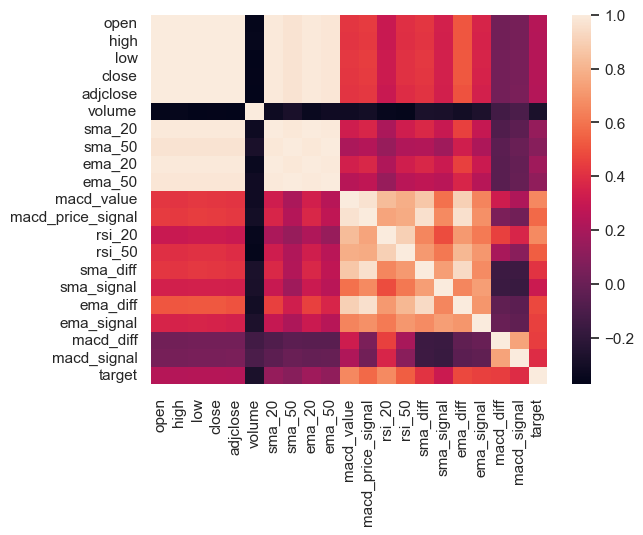

In [13]:
stock_corr = stock_df.corr(numeric_only=True)
sns.heatmap(stock_corr);

##### With Respect to the Target Column

In [14]:
stock_corr_abs = stock_corr.abs()
stock_corr_abs['target'].sort_values(ascending=False)[1:]

rsi_20               0.664626
macd_value           0.656996
macd_price_signal    0.568177
rsi_50               0.533567
ema_diff             0.474351
ema_signal           0.455040
macd_diff            0.446034
sma_diff             0.411804
macd_signal          0.393165
sma_signal           0.309446
volume               0.274407
low                  0.243359
close                0.239448
open                 0.238639
adjclose             0.238289
high                 0.234320
ema_20               0.171871
sma_20               0.137571
ema_50               0.124479
sma_50               0.093666
Name: target, dtype: float64

#### Remove Low to No Correlation Columns
Since all the individual indicator columns (except RSI) and volume column are of low to no correlation to the target, I will remove these columns to minimize unneccessary noise in the data. I will also keep a copy of the full dataset for data visualisation in the later sections.

In [15]:
full_stock_df = stock_df.copy()
stock_df = stock_df.drop(columns=['open', 'high', 'low', 'close', 'adjclose', 'volume', 'sma_20', 'sma_50', 'ema_20', 'ema_50'])
stock_df

date  macd_value  macd_price_signal     rsi_20     rsi_50   
0    2014-09-23    0.000000           0.000000        NaN        NaN  \
1    2014-09-24   -0.004992          -0.002773        NaN        NaN   
2    2014-09-25   -0.036440          -0.016571        NaN        NaN   
3    2014-09-26   -0.023855          -0.019039        NaN        NaN   
4    2014-09-29   -0.022881          -0.020182        NaN        NaN   
...         ...         ...                ...        ...        ...   
1323 2019-12-24    1.656653           1.501481  72.396576  67.190754   
1324 2019-12-26    1.781618           1.557508  75.618908  68.708110   
1325 2019-12-27    1.857027           1.617412  75.438087  68.644920   
1326 2019-12-30    1.929248           1.679779  76.368056  69.098308   
1327 2019-12-31    2.006325           1.745089  77.479561  69.652815   

      sma_diff  sma_signal  ema_diff  ema_signal  macd_diff  macd_signal   
0          NaN       False  0.000000       False   0.000000        False  \
1          NaN       False -0.003337       False  -0.002219        False   
2          NaN       False -0.024168       False  -0.019869        False   
3          NaN       False -0.016835       False  -0.004817        False   
4          NaN       False -0.016571       False  -0.002700        False   
...        ...         ...       ...         ...        ...          ...   
1323  2.858649        True  3.248426        True   0.155172         True   
1324  2.905949        True  3.349748        True   0.224109         True   
1325  2.903299        True  3.423775        True   0.239615         True   
1326  2.925474        True  3.499427        True   0.249469         True   
1327  3.007899        True  3.581952        True   0.261236         True   

      target  
0      False  
1      False  
2      False  
3      False  
4      False  
...      ...  
1323    True  
1324    True  
1325    True  
1326    True  
1327    True  

[1328 rows x 12 columns]

#### Filter the Dataset to Only Include Entries from 2015-01-01 to 2019-12-31
For this project, I will only be focussing on trading days between 2015-01-01 and 2019-12-31, hence I will remove other rows whose dates do not lie within this range.

In [16]:
full_stock_df = full_stock_df[start_date <= full_stock_df['date']]
full_stock_df = full_stock_df.reset_index(drop=True)
stock_df = stock_df[start_date <= stock_df['date']]
stock_df = stock_df.reset_index(drop=True)
stock_df.to_csv(f'{data_dir}aapl_stock_cleaned.csv')
stock_df

date  macd_value  macd_price_signal     rsi_20     rsi_50   
0    2015-01-02   -0.054420           0.010108  45.815963  51.201749  \
1    2015-01-05   -0.159254          -0.023765  40.582154  47.960590   
2    2015-01-06   -0.239371          -0.066886  40.605348  47.971504   
3    2015-01-07   -0.269786          -0.107466  44.031173  49.578887   
4    2015-01-08   -0.208214          -0.127615  52.110085  53.639699   
...         ...         ...                ...        ...        ...   
1253 2019-12-24    1.656653           1.501481  72.396576  67.190754   
1254 2019-12-26    1.781618           1.557508  75.618908  68.708110   
1255 2019-12-27    1.857027           1.617412  75.438087  68.644920   
1256 2019-12-30    1.929248           1.679779  76.368056  69.098308   
1257 2019-12-31    2.006325           1.745089  77.479561  69.652815   

      sma_diff  sma_signal  ema_diff  ema_signal  macd_diff  macd_signal   
0     0.049325        True  0.201872        True  -0.064528        False  \
1    -0.082475       False  0.116552        True  -0.135489        False   
2    -0.198875       False  0.042139        True  -0.172485        False   
3    -0.269650       False -0.002563       False  -0.162320        False   
4    -0.331425       False  0.014529        True  -0.080598        False   
...        ...         ...       ...         ...        ...          ...   
1253  2.858649        True  3.248426        True   0.155172         True   
1254  2.905949        True  3.349748        True   0.224109         True   
1255  2.903299        True  3.423775        True   0.239615         True   
1256  2.925474        True  3.499427        True   0.249469         True   
1257  3.007899        True  3.581952        True   0.261236         True   

      target  
0       True  
1       True  
2       True  
3      False  
4      False  
...      ...  
1253    True  
1254    True  
1255    True  
1256    True  
1257    True  

[1258 rows x 12 columns]

#### Final Verification of No NULL Values
The final dataset to be used for training, validating and testing the machine learning models has no null values, and all values are of the right data type.

In [17]:
stock_df.isnull().sum()

date                 0
macd_value           0
macd_price_signal    0
rsi_20               0
rsi_50               0
sma_diff             0
sma_signal           0
ema_diff             0
ema_signal           0
macd_diff            0
macd_signal          0
target               0
dtype: int64

## 3) Methodology

### Split the Dataset into Train, Validation and Test Datasets
Since the dataset is a time series data, I will not randomly select parts of the dataset as the train data, instead, I will select the earliest 60% of the dataset as the train dataset, the next 20% as the validation dataset, and use the remaining latest 20% of the dataset as the test dataset. The train dataset will consist of data from 2015-01-02 to 2017-12-28, the validation dataset will consist of data from 2017-12-29 to 2018-12-31, whereas the test dataset will consist of data from 2019-01-02 to 2019-12-31.

The input will include the following features:
- macd_value
- macd_price_signal
- rsi_20
- rsi_50
- sma_diff
- sma_signal
- ema_diff
- ema_signal
- macd_diff
- macd_signal

The output will be a buy or sell signal:
- 1 = Buy
- 0 = Sell

In [18]:
valid_index = int(len(stock_df) * 0.6)
test_index = int(len(stock_df) * 0.8)

train_data = stock_df[:valid_index]
train_data.to_csv(f'{data_dir}aapl_stock_train.csv')
train_start = train_data.iloc[0].date
train_end = train_data.iloc[-1].date
x_train = train_data.drop(columns=['date', 'target'])
y_train = train_data['target']

valid_data = stock_df[valid_index:test_index]
valid_data.to_csv(f'{data_dir}aapl_stock_validation.csv')
valid_start = valid_data.iloc[0].date
valid_end = valid_data.iloc[-1].date
x_valid = valid_data.drop(columns=['date', 'target'])
y_valid = valid_data['target']

test_data = stock_df[test_index:]
test_data.to_csv(f'{data_dir}aapl_stock_test.csv')
test_start = test_data.iloc[0].date
test_end = test_data.iloc[-1].date
x_test = test_data.drop(columns=['date', 'target'])
y_test = test_data['target']

x_cols = train_data.columns
y_classes = ['Sell', 'Buy']

In [19]:
print(f'''Train Dataset from {str(train_start.date())} to {str(train_end.date())}
Shape of Train Dataset = {train_data.shape}
Shape of X Train Data = {x_train.shape}
Shape of Y Train Data = {y_train.shape}

Validation Dataset from {str(valid_start.date())} to {str(valid_end.date())}
Shape of Validation Dataset = {valid_data.shape}
Shape of X Validation Data = {x_valid.shape}
Shape of Y Validation Data = {y_valid.shape}

Test Dataset from {str(test_start.date())} to {str(test_end.date())}
Shape of Test Dataset = {test_data.shape}
Shape of X Test Data = {x_test.shape}
Shape of Y Test Data = {y_test.shape}''')

Train Dataset from 2015-01-02 to 2017-12-28
Shape of Train Dataset = (754, 12)
Shape of X Train Data = (754, 10)
Shape of Y Train Data = (754,)

Validation Dataset from 2017-12-29 to 2018-12-31
Shape of Validation Dataset = (252, 12)
Shape of X Validation Data = (252, 10)
Shape of Y Validation Data = (252,)

Test Dataset from 2019-01-02 to 2019-12-31
Shape of Test Dataset = (252, 12)
Shape of X Test Data = (252, 10)
Shape of Y Test Data = (252,)


### The RandomForestClassifier Model
Random forest is a popular and powerful ensemble learning method for classification tasks. It is a type of decision tree algorithm that combines the predictions of multiple decision trees to make a final classification decision. The "forest" in random forest is a collection of decision trees, each of which is trained on a random subset of the data and a random subset of the input features. During training, each decision tree is grown using a process called recursive partitioning, where the algorithm splits the data into smaller and smaller subsets based on the values of the input features.

The key idea behind random forests is that by averaging the predictions of multiple decision trees, the final prediction is less sensitive to the noise or variation in any one tree. This helps to reduce overfitting and increase the model's generalization performance. In the case of classification tasks, the final prediction of a random forest is typically determined by majority voting. This means that each tree's prediction is counted as a "vote" for a particular class, and the class with the most votes is chosen as the final prediction.

Lastly, random forest models can provide information about the relative importance of each feature in making the classification decision. This could be useful in feature selections or increasing the interpretability of the model.

#### Obtain HyperParameters for the RandomForestClassifier Model
For a start, I will be using the default hyperparameters for the RandomForestClassifier model.

In [20]:
randfor_model = RandomForestClassifier(n_jobs=-1, random_state=random_state)
randfor_model_params = randfor_model.get_params()
randfor_model_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

#### Train, Validate and Test RandomForestClassifier Model
I have chosen to use the RandomForestClassifier Model as the base model due to its ability to model complex decision boundaries by combining the predictions of multiple decision trees. This is particularly useful since the relationship between the dataset's input features and the target variable is non-linear. 

After fitting the model to the x_train and y_train dataset, I will use the trained model to make classifications based on x_valid, and compare the predicted results with the true target values y_valid. From there, I will manually tune the model's hyperparamters to maximize its performance. Afterwards, I will use the tuned model to run classification on x_test, compare these classifications to the true values, y_test, and measure the model's effectiveness by calculating the Accuracy, TPR, TNR, FPR and FNR of its classification.

In [21]:
def train_test_eval(model, x_train, y_train, x_test, y_test, dataset, test_data=full_stock_df, valid_index=valid_index, test_index=test_index):
    model.fit(x_train, y_train)
    model_pred = model.predict(x_test)
    model_confmat = confusion_matrix(y_test, model_pred)
    model_confmat_dp = ConfusionMatrixDisplay(model_confmat)
    model_confmat_dp.plot()
    model_confmat_dp.ax_.set_title(f'Confusion Matrix for {type(model).__name__} Model on {dataset} Dataset');

    TN, FP, FN, TP = model_confmat[0][0], model_confmat[0][1], model_confmat[1][0], model_confmat[1][1]
    model_metrics = {
        'Accuracy': round((TP + TN) / (TP + FP + TN + FN), 4),
        'TPR': round(TP / (TP + FN), 4),
        'TNR': round(TN / (TN + FP), 4),
        'FPR': round(FP / (FP + TN), 4),
        'FNR': round(FN / (TP + FN), 4),
    }

    for metric in model_metrics:
        print(f'{metric} = {model_metrics[metric]}')

    if dataset == 'Train':
        test_data = test_data[:valid_index].copy()
    elif dataset == 'Validation':
        test_data = test_data[valid_index:test_index].copy()
    else:
        test_data = test_data[test_index:].copy()
    test_data['pred'] = model_pred
    test_fig = plotCandle(test_data)
    test_fig = plotSignals(test_fig, test_data, 'target', id=1)
    test_fig = plotSignals(test_fig, test_data, 'pred', id=2)
    test_fig.update_layout(title_text=f'True VS Predicted Buy and Sell Signals on {dataset} Dateset for {type(model).__name__}')

    return model_metrics, model_confmat, model_pred, test_fig

train_results = {}
valid_results = {}
test_results = {}

##### RandomForestClassfier Training Results
The RandomForestClassfier model seems to have exactly fit the training dataset and achieve the following the results on the training dataset:
- Perfect Accuracy of 1.0
- Perfect TPR of 1.0
- Perfect TNR of 1.0
- Perfect FPR of 0.0
- Perfect FNR of 0.0

Accuracy = 1.0
TPR = 1.0
TNR = 1.0
FPR = 0.0
FNR = 0.0


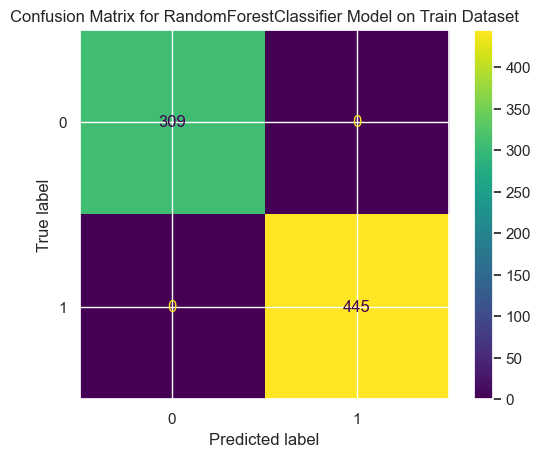

In [22]:
randfor_train_metrics, randfor_train_confmat, randfor_train_pred, randfor_train_fig = train_test_eval(randfor_model, x_train, y_train, x_train, y_train, 'Train')
train_results[f'{type(randfor_model).__name__}'] = randfor_train_metrics
randfor_train_fig.show()

##### RandomForestClassifier Validation Results
The RandomForestClassifier model has managed to achieve the following results on the validation dataset:
- High Accuracy of 0.8651
- High TPR of 0.8806
- High TNR of 0.8475
- Low FPR of 0.1525
- Low FNR of 0.1194

One noteworthy observation is that the RandomForestClassifier model managed to perfectly fit the training dataset, hence when comparing the results of the validation to the training, the model performed significantly worse. Given that tree-based models are more prone to overfitting compared to other models, it is likely that the model has over-fitted the training dataset, which made it unable to capture the general trend in the data.

Accuracy = 0.8651
TPR = 0.8806
TNR = 0.8475
FPR = 0.1525
FNR = 0.1194


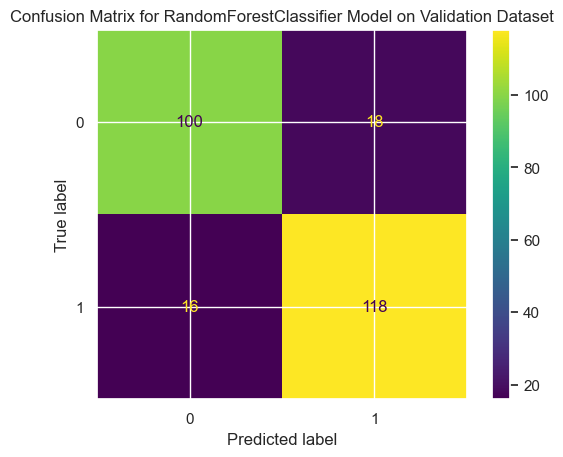

In [23]:
randfor_valid_metrics, randfor_valid_confmat, randfor_valid_pred, randfor_valid_fig = train_test_eval(randfor_model, x_train, y_train, x_valid, y_valid, 'Validation')
randfor_valid_fig.show()

##### Tune RandomForestClassifier's HyperParameters
After manual trial and error on various hyperparameters for the RandomForestClassifier model, I found that the best modification to the model would be to change its n_estimators value from the default 100 to 150. 

In the RandomForestClassifier model:
- n_estimators represents the number of trees to have in the forest. In this case, having more trees was beneficial as it likely allowed the model to capture the general trends more effectively and reduce overfitting, making the model less affected by outliers or unneccessary noise in the data and increasing the accuracy of the model.

The tuned RandomForestClassifier model managed to achieve the following results on the following dataset:
- High Accuracy of 0.873
- High TPR of 0.8806
- High TNR of 0.8644
- Low FPR of 0.1356
- Low FNR of 0.1194

Comparing the tuned model to the original model, the tuned RandomForestClassifier model has improved in the following ways:
- Accuracy increased by 0.0079
- TNR increased by 0.0169
- FPR decreased by 0.0169

Accuracy = 0.873
TPR = 0.8806
TNR = 0.8644
FPR = 0.1356
FNR = 0.1194


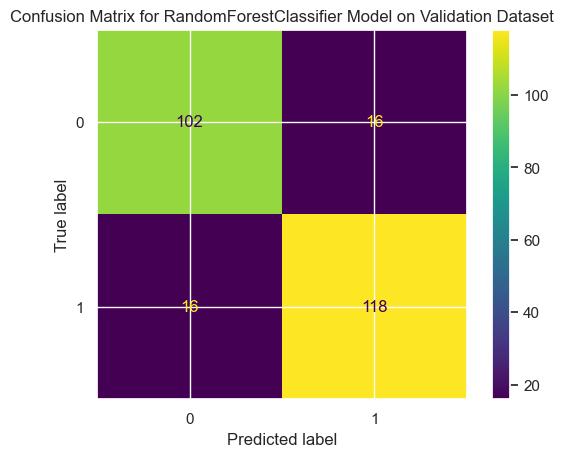

In [24]:
randfor_tuned_model = RandomForestClassifier(n_jobs=-1, random_state=random_state, n_estimators=150)
randfor_tuned_metrics, randfor_tuned_confmat, randfor_tuned_pred, randfor_tuned_fig = train_test_eval(randfor_tuned_model, x_train, y_train, x_valid, y_valid, 'Validation')
valid_results[f'{type(randfor_tuned_model).__name__}'] = randfor_tuned_metrics
randfor_tuned_fig.show()

##### RandomForestClassifier Test Results
The RandomForestClassifier model has managed to achieved the following results in the final test dataset:
- High Accuracy of 0.9325
- High TPR of 0.9375
- High TNR of 0.9091
- Low FPR of 0.0909
- Low FNR of 0.0625

Accuracy = 0.9325
TPR = 0.9375
TNR = 0.9091
FPR = 0.0909
FNR = 0.0625


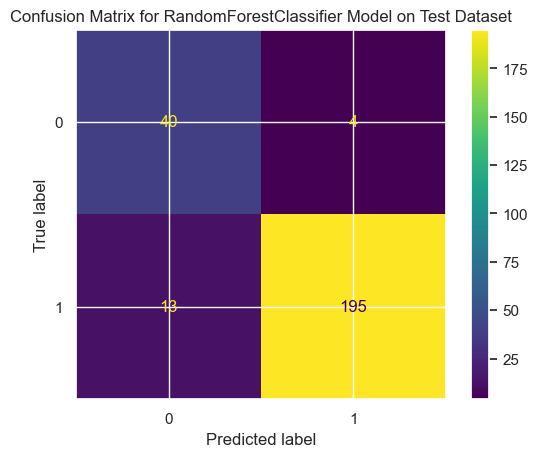

In [25]:
randfor_test_metrics, randfor_test_confmat, randfor_test_pred, randfor_test_fig = train_test_eval(randfor_tuned_model, x_train, y_train, x_test, y_test, 'Test')
test_results[f'{type(randfor_tuned_model).__name__}'] = randfor_test_metrics
randfor_test_fig.show()

##### RandomForestClassifier Feature Importances
It seems the most important variables that the model used to classify the buy and sell decisions were the macd_value, rsi_20 and macd_price_signal.

In [26]:
def plotBar(x, y, title):
    fig = go.Figure()
    fig.add_bar(
        x=x,
        y=y,
    )
    fig.update_layout(title_text=title)
    fig.show()
    return fig

randfor_impt_fig = plotBar(
    x_train.columns, 
    randfor_model.feature_importances_, 
    'Feature Importances of RandomForestClassifier',
    )

## 4) Experiments
For my experiments, I will be experimenting with 3 different classification models:
- DecisionTreeClassifier
- SGDClassifier
- LogisticRegression

To measure the effectiveness of the experiments and compare them with the baseline RandomForestClassifier model, I will use the following metrics:
- Accuracy = Proportion of predictions that are correctly predicted as True and correctly predicted as False = (TP + TN) / (TP + TN + FP + FN)
- TPR = The probability that an actual positive will be predicted as positive = (TP / (TP + FN))
- TNR = The probability that an actual negative will be predicted as negative = (TN / (TN + FP))
- FPR = The probability that an actual negative will be predicted as positive = (FP / (FP + TN))
- FNR = The probability that an actual positive will be predicted as negative = (FN / (TP + FN))

Since accuracy is the metric that accounts for both true positive and true negatives out of all the predictions made, I will prioritise the accuracy metric over all the other metrics in comparing model performance.

After analysing each model's effectiveness, I will attempt to tune the hyperparameters of all the models to maximize each model's performance using the validation dataset. Once all the models are tuned, I will test the tuned models using the final test dataset.

### The DecisionTreeClassifier Model
The DecisionTreeClassifier is a classification algorithm that belongs to the family of tree-based models. It builds a decision tree by recursively splitting the data into subsets based on the values of different input features, and then assigning a label to each subset based on the majority class within it. This process is repeated until all instances in the data have been assigned a label. The algorithm works by selecting the best feature to split the data based on some criteria (such as information gain or Gini impurity) at each node. This process is repeated for each resulting subset until a stopping criterion is met, such as reaching a minimum number of instances in a leaf node or a maximum depth for the tree.

The advantage to this model is its ability to use different subsets of features by breaking down complex data into smaller parts, as well as utilise different rules in making its decisions at different stages of classification. This could be particularly useful if the data has a large amount of data and a high number of highly-correlated variables that could significantly affect the model's ability to make decisions.

Overall, the DecisionTreeClassifier is a powerful and interpretable model that can handle both categorical and continuous input features. It can also handle missing values, although some techniques such as imputation may need to be used to handle these missing values.

#### Obtain HyperParameters for DecisionTreeClassifier Model
As a start, I will use the default hyperparameters for the DecisionTreeClassifier model.

In [27]:
dectree_model = DecisionTreeClassifier(random_state=random_state)
dectree_model_params = dectree_model.get_params()
dectree_model_params

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

#### Train, Validate and Test DecisionTreeClassifier Model
The DecisionTreeClassifier model is a possible model I could use since the dataset consists of quite a number of variables that are medium to highly correlated to my target buy or sell signals.

##### DecisionTreeClassifier Training Results
The DecisionTreeClassifier model seems to exactly fit the training dataset and achieve the following results on the training dataset:
- Perfect Accuracy of 1.0
- Perfect TPR of 1.0
- Perfect TNR of 1.0
- Perfect FPR of 0.0
- Perfect FNR of 0.0

Accuracy = 1.0
TPR = 1.0
TNR = 1.0
FPR = 0.0
FNR = 0.0


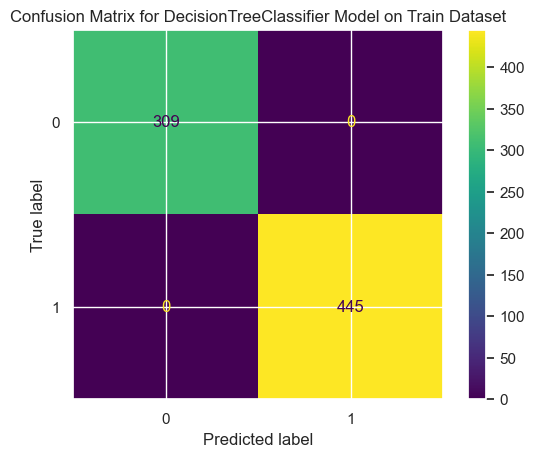

In [28]:
dectree_train_metrics, dectree_train_confmat, dectree_train_pred, dectree_train_fig = train_test_eval(dectree_model, x_train, y_train, x_train, y_train, 'Train')
train_results[f'{type(dectree_model).__name__}'] = dectree_train_metrics
dectree_train_fig.show()

##### Visualise the DecisionTreeClassifier Model
This is to visualise exactly how this model makes it decisions and classifies the data into a buy or a sell signal. By observation, there are a total of 44 leaf nodes in the decision tree.

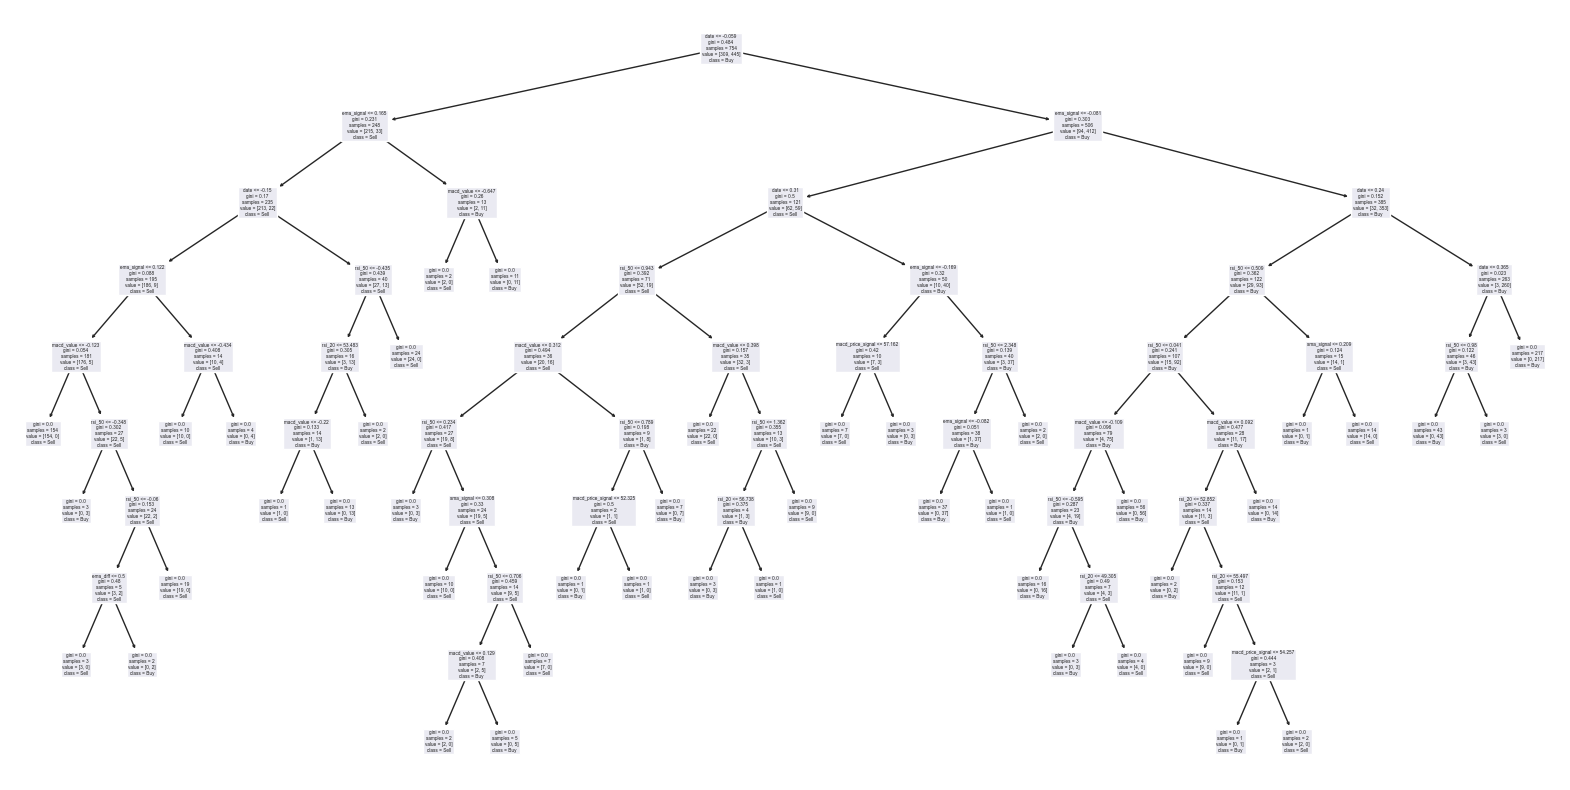

In [29]:
plt.figure(figsize=(20, 10))
plot_tree(dectree_model, feature_names=x_cols, class_names=y_classes);

##### DecisionTreeClassifier Validation Results
The DecisionTreeClassifier model has managed to achieve the following results on the validation dataset:
- High Accuracy of 0.8889
- High TPR of 0.903
- High TNR of 0.8729
- Low FPR of 0.1271
- Low FNR of 0.097

Similar to the baseline RandomForestClassifier model, the DecisionTreeClassifier model has also perfectly fit the training datase. Thus, when comparing the validation results to the training results, the model has performed significantly worse on the validation dataset. This could also be due to the DecisionTreeClassifier overfitting the training data, hindering its prediction ability on new, unseen data.

Accuracy = 0.8889
TPR = 0.903
TNR = 0.8729
FPR = 0.1271
FNR = 0.097


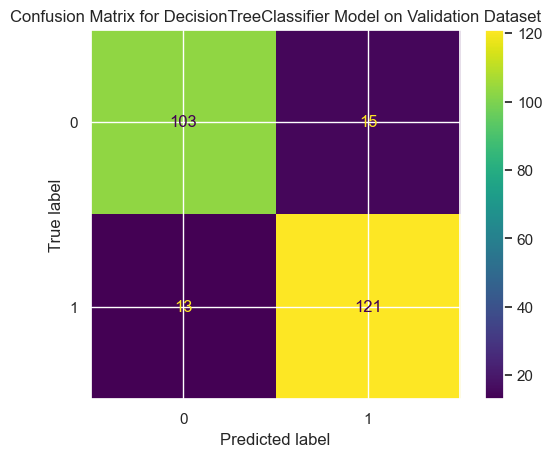

In [30]:
dectree_valid_metrics, dectree_valid_confmat, dectree_valid_pred, dectree_valid_fig = train_test_eval(dectree_model, x_train, y_train, x_valid, y_valid, 'Validation')
dectree_valid_fig.show()

##### Tune DecisionTreeClassifier HyperParameters
After manual trial and error on various hyperparameters for the DecisionTreeClassifier model, I found that the best modification to the model would be to were increasing the min_samples_leaf from 1 to 3, and limiting the max_leaf_nodes to 35. 

In the DecisionTreeClassifier model:
- min_samples_leaf represents the minimum number of samples required to be at a leaf node. By increasing this value, the DecisionTreeClassifier model will have fewer leaf nodes since each leaf node must now have a minimum number of samples in order to make a decision, which decreases overfitting of the model on the data.
- max_leaf_nodes represents the maximum number of leaf nodes that the model can have. In this case, decreasing it simplified the DecisionTreeClassifier model and made it less prone to overfitting, which hence improves its prediction ability on new, unseen data like the test dataset.

The tuned DecisionTreeClassifier model managed to achieve the following results on the following dataset:
- High Accuracy of 0.9087
- High TPR of 0.9403
- High TNR of 0.8729
- Low FPR of 0.1271
- Low FNR of 0.0597

Comparing the tuned model to the original model, the tuned DecisionTreeClassifier model has improved in the following ways:
- Accuracy increased by 0.0198
- TPR increased by 0.0373
- FNR decreased by 0.0373

Accuracy = 0.9087
TPR = 0.9403
TNR = 0.8729
FPR = 0.1271
FNR = 0.0597


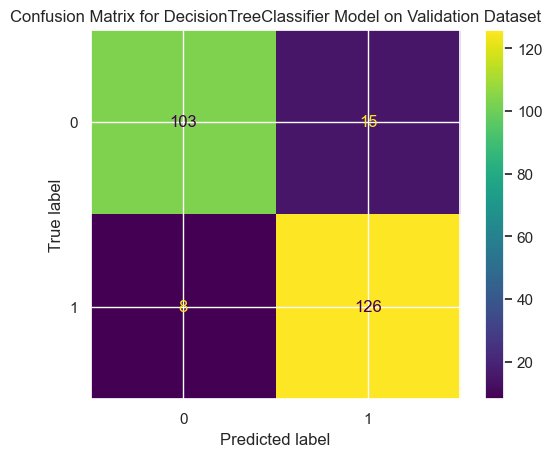

In [31]:
dectree_tuned_model = DecisionTreeClassifier(random_state=random_state, min_samples_leaf=3, max_leaf_nodes=35)
dectree_tuned_metrics, dectree_tuned_confmat, dectree_tuned_pred, dectree_tuned_fig = train_test_eval(dectree_tuned_model, x_train, y_train, x_valid, y_valid, 'Validation')
valid_results[f'{type(dectree_tuned_model).__name__}'] = dectree_tuned_metrics
dectree_tuned_fig.show()

##### Visualise the Tuned DecisionTreeClassifier Model
After tuning, there only 35 leaf nodes, as compared to the previous 44 leaf nodes, which indicates that the model is now less over-fitted.

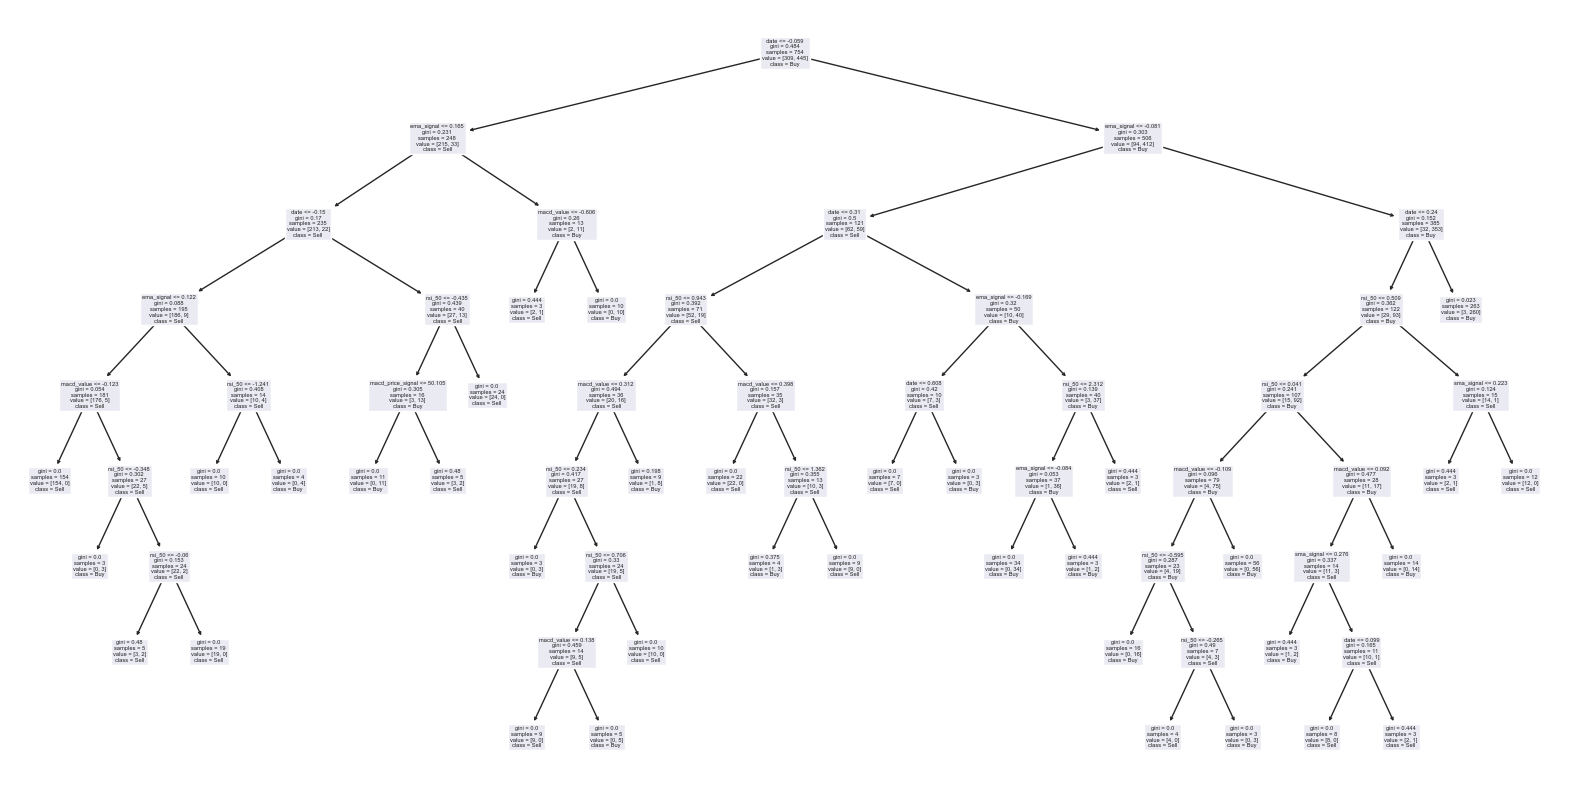

In [32]:
plt.figure(figsize=(20, 10))
plot_tree(dectree_tuned_model, feature_names=x_cols, class_names=y_classes);

##### DecisionTreeClassifier Test Results
The DecisionTreeClassifier model has managed to achieve the following results on the final test dataset:
- High Accuracy of 0.9286
- High TPR of 0.9183
- High TNR of 0.9773
- Low FPR of 0.0227
- Low FNR of 0.0817

Accuracy = 0.9286
TPR = 0.9183
TNR = 0.9773
FPR = 0.0227
FNR = 0.0817


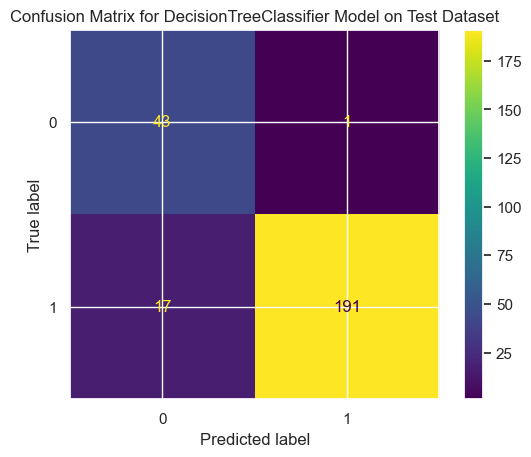

In [33]:
dectree_test_metrics, dectree_test_confmat, dectree_test_pred, dectree_test_fig = train_test_eval(dectree_tuned_model, x_train, y_train, x_test, y_test, 'Test')
test_results[f'{type(dectree_tuned_model).__name__}'] = dectree_test_metrics
dectree_test_fig.show()

##### DecisionTreeClassifier Feature Importances
It seems the top 3 features that were important in the classification decision were macd_value, sma_diff and macd_diff.

In [34]:
dectree_impt_fig = plotBar(
    x_train.columns, 
    dectree_tuned_model.feature_importances_, 
    'Feature Importances of DecisionTreeClassifier',
    )

### The SGDClassifier Model
SGDClassifier stands for Stochastic Gradient Descent Classifier. It is a linear classifier that is trained using stochastic gradient descent. This means that during the training process, the model updates its parameters based on small batches of training data instead of the entire dataset at once. It supports different loss functions, such as hinge loss (for linear SVM) and log loss (for logistic regression), and it can handle both binary and multiclass classification problems effectively as well.

The main advantage of this model is its efficiency in large-scale and sparse datasets, as well as its ability to handle high-dimensional data with ease. 

#### Obtain HyperParameters for SGDClassifier Model
As a start, I will user the default hyperparameters for the SGDClassifier model.

In [35]:
sgd_model = SGDClassifier(n_jobs=-1, random_state=random_state)
sgd_model_params = sgd_model.get_params()
sgd_model_params

{'alpha': 0.0001,
 'average': False,
 'class_weight': None,
 'early_stopping': False,
 'epsilon': 0.1,
 'eta0': 0.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'learning_rate': 'optimal',
 'loss': 'hinge',
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': -1,
 'penalty': 'l2',
 'power_t': 0.5,
 'random_state': 1,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

#### Train, Validate and Test SGDClassifier Model
Since the dataset has many data features, this model would be able to fit onto the data more effectively and efficienctly compared to other models, which could lead to stronger classification ability.

##### SGDClassifier Training Results
The SGDClassifier model has managed to achieve the following results on the training dataset:
- High Accuracy of 0.8541
- High TPR of 0.8157
- High TNR of 0.9094
- Low FPR of 0.0906
- Low FNR of 0.1843

Accuracy = 0.8541
TPR = 0.8157
TNR = 0.9094
FPR = 0.0906
FNR = 0.1843


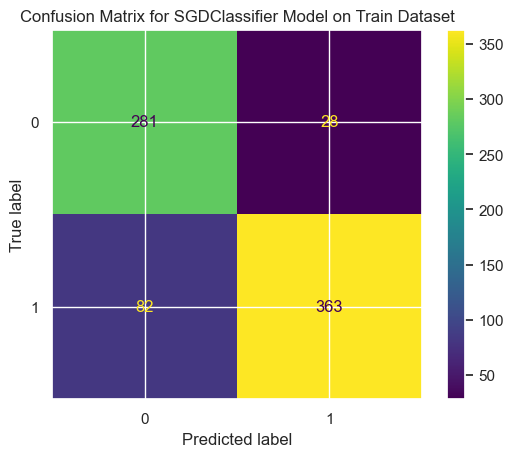

In [36]:
sgd_train_metrics, sgd_train_confmat, sgd_train_pred, sgd_train_fig = train_test_eval(sgd_model, x_train, y_train, x_train, y_train, 'Train')
train_results[f'{type(sgd_model).__name__}'] = sgd_train_metrics
sgd_train_fig.show()

##### SGDClassifier Validation Results
The SGDClassifier model has managed to achieve the following results on the validation dataset:
- High Accuracy of 0.8294
- High TPR of 0.8284
- High TNR of 0.8305
- Low FPR of 0.1695
- Low FNR of 0.1716

These validation results are comparable to the training dataset, which is an indicator that the model is not over or under-fitted on the data.

Accuracy = 0.8294
TPR = 0.8284
TNR = 0.8305
FPR = 0.1695
FNR = 0.1716


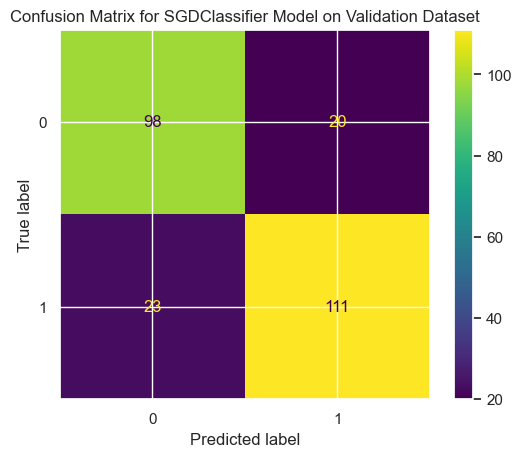

In [37]:
sgd_valid_metrics, sgd_valid_confmat, sgd_valid_pred, sgd_valid_fig = train_test_eval(sgd_model, x_train, y_train, x_valid, y_valid, 'Validation')
sgd_valid_fig.show()

##### Tune SGDClassifier HyperParameters
After manually tuning the hyperparameter, I found that the default hyperparameters still performed the best, hence I will not be making any modifications to this model.

Accuracy = 0.8294
TPR = 0.8284
TNR = 0.8305
FPR = 0.1695
FNR = 0.1716


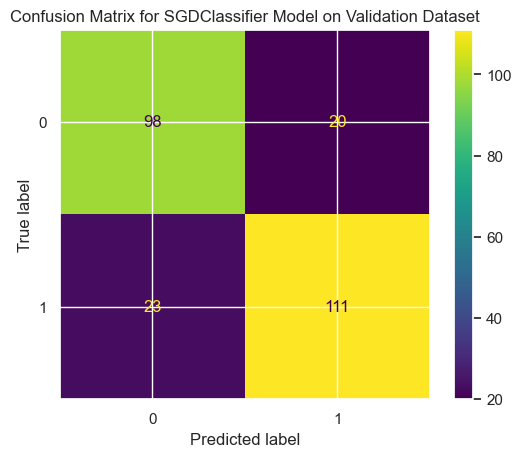

In [38]:
sgd_tuned_model = SGDClassifier(n_jobs=-1, random_state=random_state)
sgd_tuned_metrics, sgd_tuned_confmat, sgd_tuned_pred, sgd_tuned_fig = train_test_eval(sgd_tuned_model, x_train, y_train, x_valid, y_valid, 'Validation')
valid_results[f'{type(sgd_tuned_model).__name__}'] = sgd_tuned_metrics
sgd_tuned_fig.show()

##### SGDClassifier Test Results
The SGDClassifier model has managed to achieve the following results on the final test dataset:
- High Accuracy of 0.9405
- High TPR of 0.9423
- High TNR of 0.9318
- Low FPR of 0.0682
- Low FNR of 0.0577

Accuracy = 0.9405
TPR = 0.9423
TNR = 0.9318
FPR = 0.0682
FNR = 0.0577


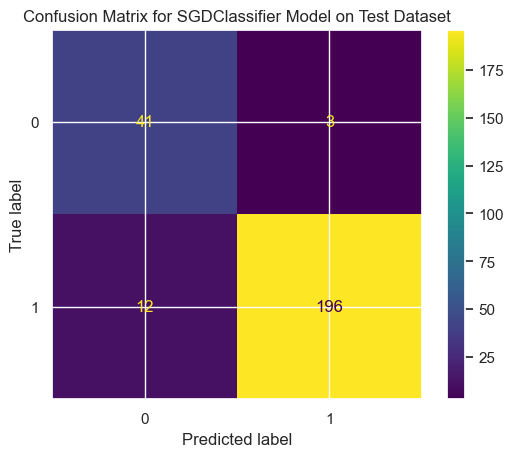

In [39]:
sgd_test_metrics, sgd_test_confmat, sgd_test_pred, sgd_test_fig = train_test_eval(sgd_tuned_model, x_train, y_train, x_test, y_test, 'Test')
test_results[f'{type(sgd_tuned_model).__name__}'] = sgd_test_metrics
sgd_test_fig.show()

##### SGDClassifier Feature Coefficients
As a larger coefficient could lead to a greater change in the result of a classification decision, I will relate a higher feature coefficient with higher importance. Hence, the top 3 most important variables were the macd_value, ema_diff and macd_price_signal.

In [40]:
sgd_coef_fig = plotBar(
    x_train.columns, 
    sgd_tuned_model.coef_[0], 
    'Feature Coefficients of SGDClassifier',
    )

### The LogisticRegression Model
LogisticRegression is a linear model that is used for binary classification. It uses the logistic function (also known as sigmoid function) to predict the probability of an input sample belonging to the positive class. The logistic function maps any input value to a value between 0 and 1, which represents the probability of the positive class. 

The main advantage of this model is its interpretability, as it provides the coefficients of the input features, which can be used to interpret the importance of each feature in the classification task.

#### Obtain HyperParameters for LogisticRegression Model
As a start, I will use the default hyperparameters for the LogisticRegression model.

In [41]:
logreg_model = LogisticRegression(n_jobs=-1, random_state=random_state)
logreg_model_params = logreg_model.get_params()
logreg_model_params

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': 1,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

#### Train, Validate and Test LogisticRegression Model
The LogisticRegression model could be beneficial since it is a model designed for binary classification, and there are only buy and sell signals, which is a binary classification problem. In addition, the data has many medium to high correlation features, so this model could help me to identify which features are more important and affect the decision making process in classifying a buy or sell signal.

##### LogisticRegression Training Results
The LogisticRegression model has managed to achieve the following results on the training dataset:
- High Accuracy of 0.9164
- High TPR of 0.9258
- High TNR of 0.9029
- Low FPR of 0.0971
- Low FNR of 0.0742

Accuracy = 0.9164
TPR = 0.9258
TNR = 0.9029
FPR = 0.0971
FNR = 0.0742


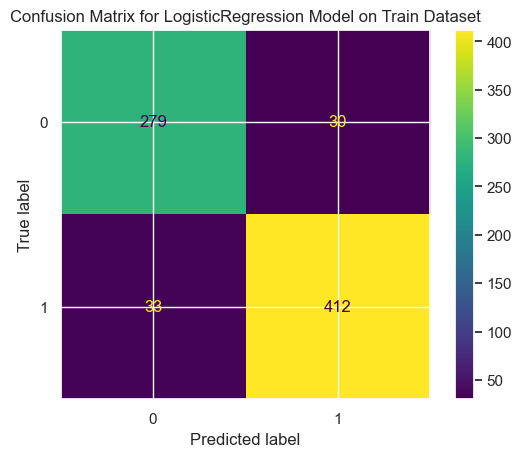

In [42]:
logreg_train_metrics, logreg_train_confmat, logreg_train_pred, logreg_train_fig = train_test_eval(logreg_model, x_train, y_train, x_train, y_train, 'Train')
train_results[f'{type(logreg_model).__name__}'] = logreg_train_metrics
logreg_train_fig.show()

##### LogisticRegression Validation Results
The LogisticRegression model has managed to achieve the following results on the validation dataset:
- High Accuracy of 0.8889
- High TPR of 0.9179
- High TNR of 0.8559
- Low FPR of 0.1441
- Low FNR of 0.0821

These validation results are comparable to the training dataset, which indicates that the model is likely not over or under-fitted on the data.

Accuracy = 0.8889
TPR = 0.9179
TNR = 0.8559
FPR = 0.1441
FNR = 0.0821


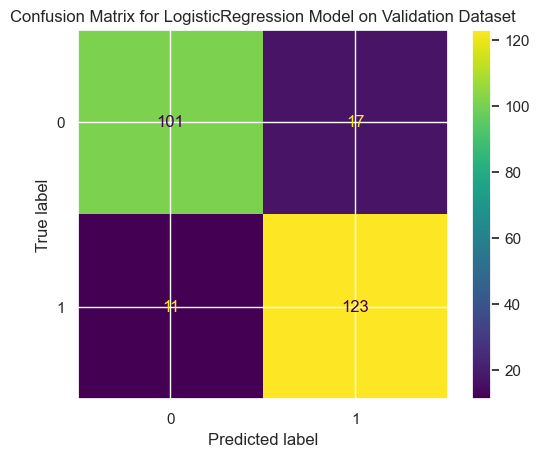

In [43]:
logreg_valid_metrics, logreg_valid_confmat, logreg_valid_pred, logreg_valid_fig = train_test_eval(logreg_model, x_train, y_train, x_valid, y_valid, 'Validation')
logreg_valid_fig.show()

##### Tune LogisticRegression HyperParameters
After manually tuning the hyperparameters, I found that the default hyperparameters still performed the best, hence I will not make any modifications to this model.

Accuracy = 0.8889
TPR = 0.9179
TNR = 0.8559
FPR = 0.1441
FNR = 0.0821


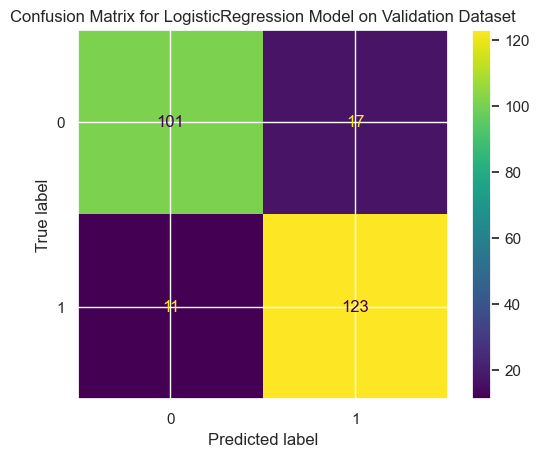

In [44]:
logreg_tuned_model = LogisticRegression(n_jobs=-1, random_state=random_state)
logreg_tuned_metrics, logreg_tuned_confmat, logreg_tuned_pred, logreg_tuned_fig = train_test_eval(logreg_tuned_model, x_train, y_train, x_valid, y_valid, 'Validation')
valid_results[f'{type(logreg_tuned_model).__name__}'] = logreg_tuned_metrics
logreg_tuned_fig.show()

##### LogisticRegression Test Results
The LogisticRegression model has managed to achieve the following results on the final test dataset:
- High Accuracy of 0.9563
- High TPR of 0.9615
- High TNR of 0.9318
- Low FPR of 0.0682
- Low FNR of 0.0385

Accuracy = 0.9563
TPR = 0.9615
TNR = 0.9318
FPR = 0.0682
FNR = 0.0385


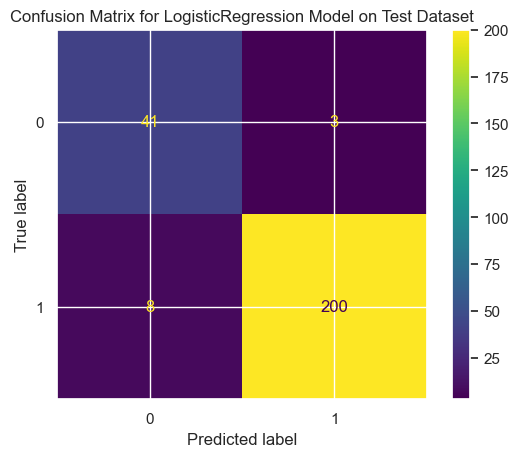

In [45]:
logreg_test_metrics, logreg_test_confmat, logreg_test_pred, logreg_test_fig = train_test_eval(logreg_tuned_model, x_train, y_train, x_test, y_test, 'Test')
test_results[f'{type(logreg_tuned_model).__name__}'] = logreg_test_metrics
logreg_test_fig.show()

##### LogisticRegression Feature Coefficients
As a larger coefficient could lead to a greater change in the result of a classification decision, I will relate a higher feature coefficient with higher importance. Hence, the top 3 most important variables were the macd_value, macd_price_signal and sma_diff.

In [46]:
logreg_coef_fig = plotBar(
    x_train.columns, 
    logreg_tuned_model.coef_[0], 
    'Feature Coefficients of LogisticRegression',
    )

### Compare the Performance of the 4 Models

#### Compare the Training Performance
Overall, all the models have managed to fit well on the train dataset, all of them managing to accurately classify a large proportion of at least 80% of the training data into buy and sell signals.

At this stage, I would rank the models in the following order:
- RandomForestClassifier and DecisionTreeClassifier, both had perfect accuracy, TPR and TNR scores
- LogisticRegression, significantly higher accuracy and TPR than the last model, although very slightly lower TNR
- SGDClassifier, significantly lower accuracy and TPR than LogisticRegression, although slightly higher TNR

In [47]:
available_models = train_results.keys()

def plotResults(models, results, dataset):
    results = pd.DataFrame(results).transpose().copy()
    fig = go.Figure()
    for model in models:
        fig.add_bar(
            x=results.columns,
            y=results.loc[model],
            name=model,
        )
    fig.update_layout(title_text=f'Results for all 4 Models on {dataset} Dataset')
    return fig

In [48]:
train_results_fig = plotResults(available_models, train_results, 'Training')
train_results_fig.show()

#### Compare the Validation Performance
Tthe RandomForestClassifier and DecisionTreeClassifier models performed significantly worse on the validation dataset compared to the training dataset, hence they were most likely over-fitted on the training dataset. After tuning their hyperparameters, I managed to improve the models' performance by reducing overfitting of the models on the data. 

The SGDClassifier and LogisticRegression models had comparable results on the training and validation data, hence were likely not under or over-fitted. I can also conclude that the best hyperparameters for those models were their default hyperparameters after much trial and error in manually tuning these parameters.

At this stage, I would rank the models in the following order:
- DecisionTreeClassifier, highest accuracy, TPR and TNR
- LogisticRegression, significantly higher accuracy and TPR than the next model, although slightly lower TNR
- RandomForestClassifier, higher accuracy, TPR and TNR than the last model
- SGDClassifier, lowest accuracy, TPR and TNR than all other models

In [49]:
valid_results_fig = plotResults(available_models, valid_results, 'Validation')
valid_results_fig.show()

#### Compare the Test Performance
In the end, all the models managed to achieve a classification accuracy of at least 0.92, which is a fantastic result as it highlights on all the models' strong classification ability.  

At this stage, I would rank the models in the following order:
- LogisticRegression, highest overall accuracy and TPR, with 2nd highest TNR
- SGDClassifier, 2nd highest overall accuracy and TPR, with highest TNR
- RandomForestClassifier, 3rd highest overall accuracy and TPR
- DecisionTreeClassifier, lowest overall accuracy and TPR, although highest TNR

In [50]:
test_results_fig = plotResults(available_models, test_results, 'Test')
test_results_fig.show()

## 5) Conclusion
In this project, I have identified and calculated relevant technical indicators for AAPL stock, and built accurate machine learning models to classify these data into buy and sell signals. To select the best model, I will place a greater weight on the test dataset since it is a dataset that is new and unseen by the models, hence it can give the greatest insight to each model's true performance. I will also place a medium weight on the validation dataset since it is also a dataset that is new and unseen to the original trained models, however, since I used the validation dataset to conduct hyperparameter tuning, and subsequently re-fit the tuned models on the validation dataset, it may not give us the most accurate representation of the model's performance. Lastly, I will place a low weight on the training dataset since it is the dataset that the models are mainly trained on. 

Since the LogisticRegression model performed the best in the final test dataset, and came in the top 2 in the validation dataset, I will consider the LogisticRegression model the best model in classifying AAPL stock data into buy and sell signals, with a final classification accuracy of 0.9563.

In addition to successfully building a model, I also demonstrated how tree-based models such as the baseline RandomForestClassifier and DecisionTreeClassifier models are more prone to overfitting as compared to other models like SGDClassifier and LogisticRegression models, and how hyperparameter tuning could be used to mitigate this and reduce overfitting. These improve the model's classification ability on new, unseen data as they are more able to capture the general trends of the respective datasets.

I also found that different models will have different decision making processes, and hence will use different features and indicators to make decisions. For example, the baseline RandomForestClassifier's decisions were more influenced by the macd_value, rsi_20 and macd_price_signal, while a similar tree-based model, the DecisionTreeClassifier, placed more emphasis on macd_value, sma_diff and macd_diff.

## 6) Limitation and Possible Improvements
One limitation is that there was an imbalance of target buy and sell signals in the data. This could potentially lead to a biasness towards a certain signal, which affects the models' overall classification performance. To mitigate this, I used hyperparameter tuning to reduce the likelihood of overfitting in the models, so that the models were more able to capture a general trend in the data, as opposed to being too biased toward a buy or a sell signal. In the future, I could select a timeframe that had a more even balance of buy and sell signals, and use that time frame to conduct the train, validation and test stages for the models, which could improve the models' classification accuracy.